# Import dependencies

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
from pysolar.solar import *
import datetime
import pytz
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from functools import partial
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', True)

# Load Data

In [3]:
GEN_DATA_PATH = os.path.join('..', '..', 'data', '1_pre_processed_data.parquet')
df = pd.read_parquet(GEN_DATA_PATH)

In [4]:
display(df.head())

,Temperature,Precipitation Total,Relative Humidity,Wind Speed,Wind Direction,Cloud Cover Total,Cloud Cover High,Cloud Cover Medium,Cloud Cover Low,CAPE,Sunshine Duration,Shortwave Radiation,Longwave Radiation,UV Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Mean Sea Level Pressure,DC Gen. Power,Device Temp.,Voltage
index,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:00:00,16.00,2.00,97.00,8.00,137.00,23.00,77.00,22.00,14.00,"1,310.00",0.00,0.00,401.00,0.00,0.00,0.00,"1,003.00",0.00,0.00,0.00
2019-10-01 01:00:00,16.00,1.00,99.00,11.00,169.00,34.00,40.00,34.00,22.00,776.00,0.00,0.00,389.00,0.00,0.00,0.00,"1,003.00",0.00,0.00,0.00
2019-10-01 02:00:00,15.00,2.00,99.00,17.00,166.00,48.00,69.00,38.00,48.00,817.00,0.00,0.00,371.00,0.00,0.00,0.00,"1,003.00",0.00,0.00,0.00
2019-10-01 03:00:00,15.00,3.00,99.00,18.00,153.00,100.00,98.00,100.00,78.00,"1,017.00",0.00,0.00,378.00,0.00,0.00,0.00,"1,002.00",0.00,0.00,0.00
2019-10-01 04:00:00,15.00,3.00,99.00,17.00,143.00,100.00,100.00,100.00,100.00,791.00,0.00,0.00,391.00,0.00,0.00,0.00,"1,002.00",0.00,0.00,0.00


# Keep existing features

In [5]:
features_to_keep = [
    'Temperature',
    'Precipitation Total',
    'Cloud Cover Total',
    'Shortwave Radiation',
    'DC Gen. Power'
]
# remove irrelevant features
df = df[features_to_keep]


In [6]:
display(df.head())

,Temperature,Precipitation Total,Cloud Cover Total,Shortwave Radiation,DC Gen. Power
index,,,,,
2019-10-01 00:00:00,16.00,2.00,23.00,0.00,0.00
2019-10-01 01:00:00,16.00,1.00,34.00,0.00,0.00
2019-10-01 02:00:00,15.00,2.00,48.00,0.00,0.00
2019-10-01 03:00:00,15.00,3.00,100.00,0.00,0.00
2019-10-01 04:00:00,15.00,3.00,100.00,0.00,0.00


# Add calculated features

### Temporal Feature Engineering

In [7]:
TARGET_COLUMN = 'DC Gen. Power'

df['hour'] = df.index.hour
df['month'] = df.index.month
df['day'] = df.index.day

df['season'] = df['month'].apply(lambda x: 0 if x in [12, 1, 2] else (1 if x in [3, 4, 5] else (2 if x in [6, 7, 8] else 3)))

In [8]:
display(df[['hour', 'month', 'day', 'season']].head(12))

,hour,month,day,season
index,,,,
2019-10-01 00:00:00,0,10,1,3
2019-10-01 01:00:00,1,10,1,3
2019-10-01 02:00:00,2,10,1,3
2019-10-01 03:00:00,3,10,1,3
2019-10-01 04:00:00,4,10,1,3
2019-10-01 05:00:00,5,10,1,3
2019-10-01 06:00:00,6,10,1,3
2019-10-01 07:00:00,7,10,1,3
2019-10-01 08:00:00,8,10,1,3


### Use one hot encoding for representing season, month and hour data

In [9]:
df = pd.concat([df, pd.get_dummies(df['season'], prefix='season')], axis=1)
df = pd.concat([df, pd.get_dummies(df['month'], prefix='month')], axis=1)
df = pd.concat([df, pd.get_dummies(df['hour'], prefix='hour')], axis=1)
df.drop(['season', 'month', 'hour'], axis=1, inplace=True)

In [10]:
display(df[['season_0', 'season_1', 'season_2', 'season_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_12', 'hour_23']].describe())

,season_0,season_1,season_2,season_3,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_12,hour_23
count,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193,27193
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,20689,20569,20569,19752,24961,25153,24961,25033,24961,25033,24961,24961,25033,24217,24888,24961,26059,26060,26060


### Lag-based feature generation

In [11]:
hours_lag= [1, 2, 4, 24, 24 * 30]
for hour in hours_lag:
    df[f'{TARGET_COLUMN} {hour} Hour Lag'] = df[TARGET_COLUMN].shift(hour)

lag_columns = [f'{TARGET_COLUMN} {hour} Hour Lag' for hour in hours_lag]

In [12]:
display(df.dropna()[[TARGET_COLUMN] + lag_columns])

,DC Gen. Power,DC Gen. Power 1 Hour Lag,DC Gen. Power 2 Hour Lag,DC Gen. Power 4 Hour Lag,DC Gen. Power 24 Hour Lag,DC Gen. Power 720 Hour Lag
index,,,,,,
2019-10-31 00:00:00,0.00,0.00,0.00,"6,744.30",0.00,0.00
2019-10-31 01:00:00,0.00,0.00,0.00,162.50,0.00,0.00
2019-10-31 02:00:00,0.00,0.00,0.00,0.00,0.00,0.00
2019-10-31 03:00:00,0.00,0.00,0.00,0.00,0.00,0.00
2019-10-31 04:00:00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...
2022-11-06 20:00:00,166.65,"3,647.24","21,521.82","76,773.42",132.54,0.00
2022-11-06 21:00:00,0.00,166.65,"3,647.24","54,696.16",0.00,0.00
2022-11-06 22:00:00,0.00,0.00,166.65,"21,521.82",0.00,0.00


### Rolling Window Features for Temporal Trends

In [13]:
rolling_windows = [24, 48, 30*24]
columns = [TARGET_COLUMN, 'Temperature','Precipitation Total', 'Cloud Cover Total','Shortwave Radiation']
for window in rolling_windows:
    for column in columns:
        df[f'{column} {window} Hour Rolling Mean'] = df[column].rolling(window).mean()
        df[f'{column} {window} Hour Rolling Std'] = df[column].rolling(window).std()
        df[f'{column} {window} Hour Rolling Max'] = df[column].rolling(window).max()
        df[f'{column} {window} Hour Rolling EMA'] = df[column].ewm(span=window).mean()

rolling_columns = df.columns[df.columns.str.contains('Rolling')]

df.dropna(inplace=True)

In [14]:
display(df[[TARGET_COLUMN] + list(rolling_columns)])

,DC Gen. Power,DC Gen. Power 24 Hour Rolling Mean,DC Gen. Power 24 Hour Rolling Std,DC Gen. Power 24 Hour Rolling Max,DC Gen. Power 24 Hour Rolling EMA,Temperature 24 Hour Rolling Mean,Temperature 24 Hour Rolling Std,Temperature 24 Hour Rolling Max,Temperature 24 Hour Rolling EMA,Precipitation Total 24 Hour Rolling Mean,Precipitation Total 24 Hour Rolling Std,Precipitation Total 24 Hour Rolling Max,Precipitation Total 24 Hour Rolling EMA,Cloud Cover Total 24 Hour Rolling Mean,Cloud Cover Total 24 Hour Rolling Std,Cloud Cover Total 24 Hour Rolling Max,Cloud Cover Total 24 Hour Rolling EMA,Shortwave Radiation 24 Hour Rolling Mean,Shortwave Radiation 24 Hour Rolling Std,Shortwave Radiation 24 Hour Rolling Max,Shortwave Radiation 24 Hour Rolling EMA,DC Gen. Power 48 Hour Rolling Mean,DC Gen. Power 48 Hour Rolling Std,DC Gen. Power 48 Hour Rolling Max,DC Gen. Power 48 Hour Rolling EMA,Temperature 48 Hour Rolling Mean,Temperature 48 Hour Rolling Std,Temperature 48 Hour Rolling Max,Temperature 48 Hour Rolling EMA,Precipitation Total 48 Hour Rolling Mean,Precipitation Total 48 Hour Rolling Std,Precipitation Total 48 Hour Rolling Max,Precipitation Total 48 Hour Rolling EMA,Cloud Cover Total 48 Hour Rolling Mean,Cloud Cover Total 48 Hour Rolling Std,Cloud Cover Total 48 Hour Rolling Max,Cloud Cover Total 48 Hour Rolling EMA,Shortwave Radiation 48 Hour Rolling Mean,Shortwave Radiation 48 Hour Rolling Std,Shortwave Radiation 48 Hour Rolling Max,Shortwave Radiation 48 Hour Rolling EMA,DC Gen. Power 720 Hour Rolling Mean,DC Gen. Power 720 Hour Rolling Std,DC Gen. Power 720 Hour Rolling Max,DC Gen. Power 720 Hour Rolling EMA,Temperature 720 Hour Rolling Mean,Temperature 720 Hour Rolling Std,Temperature 720 Hour Rolling Max,Temperature 720 Hour Rolling EMA,Precipitation Total 720 Hour Rolling Mean,Precipitation Total 720 Hour Rolling Std,Precipitation Total 720 Hour Rolling Max,Precipitation Total 720 Hour Rolling EMA,Cloud Cover Total 720 Hour Rolling Mean,Cloud Cover Total 720 Hour Rolling Std,Cloud Cover Total 720 Hour Rolling Max,Cloud Cover Total 720 Hour Rolling EMA,Shortwave Radiation 720 Hour Rolling Mean,Shortwave Radiation 720 Hour Rolling Std,Shortwave Radiation 720 Hour Rolling Max,Shortwave Radiation 720 Hour Rolling EMA
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31 00:00:00,0.00,"20,702.05","25,422.50","97,134.20","22,580.75",16.67,1.37,19.00,16.70,0.08,0.28,1.00,0.08,50.04,31.93,97.00,38.29,137.79,155.40,436.00,136.49,"28,375.58","39,447.88","132,528.90","26,008.70",16.54,1.25,19.00,17.06,0.04,0.20,1.00,0.09,54.77,36.02,100.00,45.32,195.50,253.31,868.00,165.52,"22,863.31","47,533.52","204,958.74","31,273.32",15.55,3.85,28.00,16.27,0.21,0.91,11.00,0.15,48.07,38.28,100.00,43.61,192.32,280.37,988.00,208.83
2019-10-31 01:00:00,0.00,"20,702.05","25,422.50","97,134.20","20,774.29",16.75,1.26,19.00,16.65,0.08,0.28,1.00,0.07,47.50,33.09,97.00,35.54,137.79,155.40,436.00,125.57,"28,375.58","39,447.88","132,528.90","24,947.12",16.52,1.25,19.00,17.02,0.04,0.20,1.00,0.09,52.77,36.12,100.00,43.64,195.50,253.31,868.00,158.77,"22,863.31","47,533.52","204,958.74","31,173.08",15.55,3.85,28.00,16.27,0.21,0.91,11.00,0.14,48.03,38.31,100.00,43.48,192.32,280.37,988.00,208.16
2019-10-31 02:00:00,0.00,"20,702.05","25,422.50","97,134.20","19,112.34",16.75,1.26,19.00,16.52,0.08,0.28,1.00,0.07,44.33,33.78,97.00,32.78,137.79,155.40,436.00,115.52,"28,375.58","39,447.88","132,528.90","23,928.87",16.50,1.27,19.00,16.94,0.04,0.20,1.00,0.09,50.71,36.19,100.00,41.90,195.50,253.31,868.00,152.29,"22,863.31","47,533.52","204,958.74","31,073.20",15.55,3.85,28.00,16.27,0.21,0.91,11.00,0.14,47.96,38.35,100.00,43.35,192.32,280.37,988.00,207.49
2019-10-31 03:00:00,0.00,"20,702.05","25,422.50","97,134.20","17,583.36",16.75,1.26,19.00,16.40,0.08,0.28,1.00,0.06,41.25,34.32,97.00,30.16,137.79,155.40,436.00,106.28,"28,375.58","39,447.88","132,528.90","22,952.18",16.48,1.29,19.00,16.86,0.04,0.20,1.00,0.08,48.62,36.17,100.00,40.19,195.50,253.31

### Additional Contextual Features

In [15]:
df['Hours Since Last Rain'] = 0
last_rain_date = None

for index, row in df.iterrows():
    if row['Precipitation Total'] > 0:
        df.at[index, 'Hours Since Last Rain'] = 0
        last_rain_date = index
    else:
        if last_rain_date is None:
            df.at[index, 'Hours Since Last Rain'] = 0
        else:
            df.at[index, 'Hours Since Last Rain'] = (index - last_rain_date).total_seconds() / 3600

### Solar Zenith Angle

In [16]:
LATITUDE = -34.68
LONGITUDE = -55.82
tz = pytz.timezone('America/Montevideo')

def get_solar_zenith_angle(row):
    time = tz.localize(row.name)
    sza = get_altitude(LATITUDE, LONGITUDE, time)
    return sza

df['Solar Zenith Angle'] = df.apply(lambda row: get_solar_zenith_angle(row), axis=1)

In [17]:
display(df[['Precipitation Total', 'Hours Since Last Rain', 'Solar Zenith Angle']])

,Precipitation Total,Hours Since Last Rain,Solar Zenith Angle
index,,,
2019-10-31 00:00:00,0.00,0,-40.93
2019-10-31 01:00:00,0.00,0,-40.70
2019-10-31 02:00:00,0.00,0,-36.53
2019-10-31 03:00:00,0.00,0,-29.24
2019-10-31 04:00:00,0.00,0,-19.82
...,...,...,...
2022-11-06 20:00:00,0.00,172,-8.83
2022-11-06 21:00:00,0.00,173,-19.30
2022-11-06 22:00:00,0.00,174,-28.30


### Identifying and Handling Outliers

In [18]:
RADIATION_THRESHOLD = 100
df_radiation_but_no_power = df[(df['DC Gen. Power'] == 0) & (df['Shortwave Radiation'] > RADIATION_THRESHOLD)]

display('Number of rows with radiation but no power: {}'.format(len(df_radiation_but_no_power)))

'Number of rows with radiation but no power: 130'

### Statistical outliers detection

In [19]:
Q1 = df['DC Gen. Power'].quantile(0.25)
Q3 = df['DC Gen. Power'].quantile(0.75)
IQR = Q3 - Q1

multiplier = 1.5

outliers = df[(df['DC Gen. Power'] < (Q1 - multiplier * IQR)) | (df['DC Gen. Power'] > (Q3 + multiplier * IQR))]

display('Number of outliers: {}'.format(len(outliers)))

'Number of outliers: 1020'

In [20]:
df = df.drop(outliers.index)
df = df.drop(df_radiation_but_no_power.index)

### Save dataset to use it in the next steps of the pipeline

In [21]:
df.to_parquet(os.path.join('..', '..', 'data', '5_training_production_model_data.parquet'))

In [22]:
df.describe()

,Temperature,Precipitation Total,Cloud Cover Total,Shortwave Radiation,DC Gen. Power,day,DC Gen. Power 1 Hour Lag,DC Gen. Power 2 Hour Lag,DC Gen. Power 4 Hour Lag,DC Gen. Power 24 Hour Lag,DC Gen. Power 720 Hour Lag,DC Gen. Power 24 Hour Rolling Mean,DC Gen. Power 24 Hour Rolling Std,DC Gen. Power 24 Hour Rolling Max,DC Gen. Power 24 Hour Rolling EMA,Temperature 24 Hour Rolling Mean,Temperature 24 Hour Rolling Std,Temperature 24 Hour Rolling Max,Temperature 24 Hour Rolling EMA,Precipitation Total 24 Hour Rolling Mean,Precipitation Total 24 Hour Rolling Std,Precipitation Total 24 Hour Rolling Max,Precipitation Total 24 Hour Rolling EMA,Cloud Cover Total 24 Hour Rolling Mean,Cloud Cover Total 24 Hour Rolling Std,Cloud Cover Total 24 Hour Rolling Max,Cloud Cover Total 24 Hour Rolling EMA,Shortwave Radiation 24 Hour Rolling Mean,Shortwave Radiation 24 Hour Rolling Std,Shortwave Radiation 24 Hour Rolling Max,Shortwave Radiation 24 Hour Rolling EMA,DC Gen. Power 48 Hour Rolling Mean,DC Gen. Power 48 Hour Rolling Std,DC Gen. Power 48 Hour Rolling Max,DC Gen. Power 48 Hour Rolling EMA,Temperature 48 Hour Rolling Mean,Temperature 48 Hour Rolling Std,Temperature 48 Hour Rolling Max,Temperature 48 Hour Rolling EMA,Precipitation Total 48 Hour Rolling Mean,Precipitation Total 48 Hour Rolling Std,Precipitation Total 48 Hour Rolling Max,Precipitation Total 48 Hour Rolling EMA,Cloud Cover Total 48 Hour Rolling Mean,Cloud Cover Total 48 Hour Rolling Std,Cloud Cover Total 48 Hour Rolling Max,Cloud Cover Total 48 Hour Rolling EMA,Shortwave Radiation 48 Hour Rolling Mean,Shortwave Radiation 48 Hour Rolling Std,Shortwave Radiation 48 Hour Rolling Max,Shortwave Radiation 48 Hour Rolling EMA,DC Gen. Power 720 Hour Rolling Mean,DC Gen. Power 720 Hour Rolling Std,DC Gen. Power 720 Hour Rolling Max,DC Gen. Power 720 Hour Rolling EMA,Temperature 720 Hour Rolling Mean,Temperature 720 Hour Rolling Std,Temperature 720 Hour Rolling Max,Temperature 720 Hour Rolling EMA,Precipitation Total 720 Hour Rolling Mean,Precipitation Total 720 Hour Rolling Std,Precipitation Total 720 Hour Rolling Max,Precipitation Total 720 Hour Rolling EMA,Cloud Cover Total 720 Hour Rolling Mean,Cloud Cover Total 720 Hour Rolling Std,Cloud Cover Total 720 Hour Rolling Max,Cloud Cover Total 720 Hour Rolling EMA,Shortwave Radiation 720 Hour Rolling Mean,Shortwave Radiation 720 Hour Rolling Std,Shortwave Radiation 720 Hour Rolling Max,Shortwave Radiation 720 Hour Rolling EMA,Hours Since Last Rain,Solar Zenith Angle
count,"25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00","25,323.00"
mean,16.39,0.09,34.50,170.05,"32,343.37",15.61,"32,818.97","33,647.57","36,325.25","33,353.28","33,578.06","37,450.96","50,762.45","141,224.76","36,890.84",16.56,2.56,20.60,16.56,0.09,0.16,0.56,0.09,34.31,19.96,70.19,34.31,195.15,249.88,676.68,192.53,"37,522.82","52,345.75","158,893.00","37,302.05",16.56,2.82,21.77,16.56,0.09,0.22,0.94,0.09,34.15,24.50,82.83,34.20,195.54,253.51,743.23,194.53,"37,664.58","54,581.67","183,665.58","37,650.21",16.58,3.67,27.37,16.59,0.09,0.46,4.91,0.09,33.96,33.57,100.00,33.99,196.21,260.61,859.53,196.22,122.87,-2.91
std,5.68,0.52,34.75,250.62,"49,388.16",8.81,"50,642.63","52,479.

# Model Training

### Split data

In [23]:
train, validate, test = np.split(df, [int(.6*len(df)), int(.8*len(df))])

x_train = train.drop(columns=[TARGET_COLUMN])
x_val = validate.drop(columns=[TARGET_COLUMN])
x_test = test.drop(columns=[TARGET_COLUMN])

y_train = train[TARGET_COLUMN]
y_val = validate[TARGET_COLUMN]
y_test = test[TARGET_COLUMN]

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

print('Train: ', len(train))
print('Validate: ', len(validate))
print('Test: ', len(test))

Train:  15193
Validate:  5065
Test:  5065


### Save scalars

In [33]:
# save x_scaler and y_scaler
import joblib

joblib.dump(x_scaler, os.path.join('..', '..', 'models', 'x_scaler.pkl'))
joblib.dump(y_scaler, os.path.join('..', '..', 'models', 'y_scaler.pkl'))

['../../models/y_scaler.pkl']

### Training

In [26]:
results = pd.DataFrame()
def calculate_metrics(y_pred, y_val, model_name, hyperparams):
    """
    Calculate metrics for the model
    """
    global results
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    print(f'Model: {model_name}')
    print(f'Hyperparameters: {hyperparams}')
    # print(f'MSE: {mse}')
    # print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    #print('\n')    

    df = pd.DataFrame({
        'model': [model_name],        
        'mae': [mae],
        'mse': [mse],
        'mae': [mae],
        'hyperparams': [hyperparams]
    })
    results = pd.concat([results, df])   

    return mse, rmse, mae

In [27]:
# train cat_boost model
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
model.fit(x_train_scaled, y_train_scaled, eval_set=(x_val_scaled, y_val_scaled))

y_pred = model.predict(x_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

calculate_metrics(y_pred, y_test, 'CatBoost', model.get_params())

Model: CatBoost
Hyperparameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'MAE', 'verbose': 0}
MAE: 5061.4395947202


(108962704.78573678, 10438.520239274185, 5061.4395947202)

# Save model

In [29]:
model.save_model(os.path.join('..', '..', 'models', 'catboost_model_production'))

# Load model

In [34]:
model = CatBoostRegressor()
model.load_model(os.path.join('..', '..', 'models', 'catboost_model_production'))

x_scaler = joblib.load(os.path.join('..', '..', 'models', 'x_scaler.pkl'))
y_scaler = joblib.load(os.path.join('..', '..', 'models', 'y_scaler.pkl'))

# Predict to verify

In [35]:
y_pred = model.predict(x_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

calculate_metrics(y_pred, y_test, 'CatBoost', model.get_params())

Model: CatBoost
Hyperparameters: {'depth': 6, 'loss_function': 'MAE', 'learning_rate': 0.1, 'iterations': 1000, 'verbose': 0}
MAE: 5061.4395947202


(108962704.78573678, 10438.520239274185, 5061.4395947202)

[[-0.09980129]
 [-0.09566898]
 [-0.14409155]
 ...
 [-7.05794186]
 [ 6.20158551]
 [ 0.04844265]]


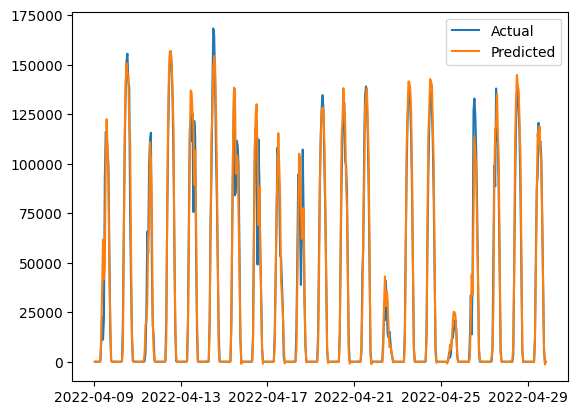

                             Temperature  Precipitation Total    Cloud Cover Total  Shortwave Radiation        DC Gen. Power  day  season_0  season_1  season_2  season_3  month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  month_11  month_12  hour_0  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  DC Gen. Power 1 Hour Lag  DC Gen. Power 2 Hour Lag  DC Gen. Power 4 Hour Lag  DC Gen. Power 24 Hour Lag  DC Gen. Power 720 Hour Lag  DC Gen. Power 24 Hour Rolling Mean  DC Gen. Power 24 Hour Rolling Std  DC Gen. Power 24 Hour Rolling Max  DC Gen. Power 24 Hour Rolling EMA  Temperature 24 Hour Rolling Mean  Temperature 24 Hour Rolling Std  Temperature 24 Hour Rolling Max  Temperature 24 Hour Rolling EMA  Precipitation Total 24 Hour Rolling Mean  Precipitation Total 24 Hour Rolling Std  Precipitation Total 24

In [42]:
print(y_pred)

# graph predictions and actual values
import matplotlib.pyplot as plt

plt.plot(y_test.index[:500], y_test[:500], label='Actual')
plt.plot(y_test.index[:500], y_pred[:500], label='Predicted')
plt.legend()
plt.show()

print(df.head())